In [45]:
import pandas as pd
import numpy as np
import re
import missingno as msno

import os
import glob

import platform
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## 3. 서울시 구별 코로나 환자수

https://www.seoul.go.kr/coronaV/coronaStatus.do

* 서울시 코로나 발생동향 페이지에서 직접 크롤링
* 매일 집계되므로 실행시 결과는 이 코드와 다릅니다

In [4]:
# 웹페이지의 '테이블' 형식 데이터는 판다스만으로 크롤링

url = 'https://www.seoul.go.kr/coronaV/coronaStatus.do'
url

'https://www.seoul.go.kr/coronaV/coronaStatus.do'

In [5]:
# 페이지에 있는 전체 테이블 (크롤링은 실시간 집계되므로 데이터가 다름)
# 재현을 위해서는 데이터를 파일로 저장해두자

pd.read_html(url)

[    강남구   강동구   강북구   강서구   관악구   광진구   구로구   금천구   노원구   도봉구  동대문구   동작구  \
 0  7408  4242  2971  4821  5761  3784  4918  2384  4277  2869  4043  4434   
 1   +37   +24   +16   +24   +23   +12   +59   +17   +26   +10   +32   +13   
 2  서대문구   서초구   성동구   성북구   송파구   양천구  영등포구   용산구   은평구   종로구    중구   중랑구   
 3  2949  4500  3064  4161  6888  3576  4888  2957  4677  1879  1922  4086   
 4   +16   +15   +12   +29   +30    +9   +29   +19   +27   +14    +9   +25   
 
     마포구  
 0  4060  
 1   +25  
 2    기타  
 3  7676  
 4   +31  ,
      강남구   강동구   강북구   강서구   관악구   광진구
 0   7408  4242  2971  4821  5761  3784
 1    +37   +24   +16   +24   +23   +12
 2    구로구   금천구   노원구   도봉구  동대문구   동작구
 3   4918  2384  4277  2869  4043  4434
 4    +59   +17   +26   +10   +32   +13
 5    마포구  서대문구   서초구   성동구   성북구   송파구
 6   4060  2949  4500  3064  4161  6888
 7    +25   +16   +15   +12   +29   +30
 8    양천구  영등포구   용산구   은평구   종로구    중구
 9   3576  4888  2957  4677  1879  1922
 10    +9   +29   +19  

In [6]:
# 한페이지 내의 전체 테이블 갯수 
table = pd.read_html(url)

len(table)

8

In [7]:
# "구별 발생 환자수" 만 필요하므로 첫번째 테이블을 사용한다
# table[1] 부터 table[7]까지 실행하여 나머지 테이블을 확인해보자 (나이대, 감염경로, 여행력, 퇴원현황 등)
table[0]

,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,도봉구,동대문구,동작구,마포구
0,7408,4242,2971,4821,5761,3784,4918,2384,4277,2869,4043,4434,4060
1,+37,+24,+16,+24,+23,+12,+59,+17,+26,+10,+32,+13,+25
2,서대문구,서초구,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구,기타
3,2949,4500,3064,4161,6888,3576,4888,2957,4677,1879,1922,4086,7676
4,+16,+15,+12,+29,+30,+9,+29,+19,+27,+14,+9,+25,+31


In [8]:
df_raw = table[0].T.reset_index()
df_raw

,index,0,1,2,3,4
0,강남구,7408,+37,서대문구,2949,+16
1,강동구,4242,+24,서초구,4500,+15
2,강북구,2971,+16,성동구,3064,+12
3,강서구,4821,+24,성북구,4161,+29
4,관악구,5761,+23,송파구,6888,+30
5,광진구,3784,+12,양천구,3576,+9
6,구로구,4918,+59,영등포구,4888,+29
7,금천구,2384,+17,용산구,2957,+19
8,노원구,4277,+26,은평구,4677,+27
9,도봉구,2869,+10,종로구,1879,+14


In [9]:
df_1 = df_raw[['index', 0]]
df_1.columns = ['시군구명', '확진자수']
df_1

,시군구명,확진자수
0,강남구,7408
1,강동구,4242
2,강북구,2971
3,강서구,4821
4,관악구,5761
5,광진구,3784
6,구로구,4918
7,금천구,2384
8,노원구,4277
9,도봉구,2869


In [10]:
df_2 = df_raw[[2, 3]]
df_2.columns = ['시군구명', '확진자수']
df_2

,시군구명,확진자수
0,서대문구,2949
1,서초구,4500
2,성동구,3064
3,성북구,4161
4,송파구,6888
5,양천구,3576
6,영등포구,4888
7,용산구,2957
8,은평구,4677
9,종로구,1879


In [11]:
df_corona = pd.concat([df_1, df_2], axis=0, ignore_index=True)
df_corona

,시군구명,확진자수
0,강남구,7408
1,강동구,4242
2,강북구,2971
3,강서구,4821
4,관악구,5761
5,광진구,3784
6,구로구,4918
7,금천구,2384
8,노원구,4277
9,도봉구,2869


In [12]:
# index 위치 이용해 사용하지 않을 '기타' 행 제거

df_corona = df_corona.drop(df_corona.index[25])
df_corona

,시군구명,확진자수
0,강남구,7408
1,강동구,4242
2,강북구,2971
3,강서구,4821
4,관악구,5761
5,광진구,3784
6,구로구,4918
7,금천구,2384
8,노원구,4277
9,도봉구,2869


In [14]:
pwd

'c:\\Users\\pc\\Desktop\\데이터스토리'

In [15]:
# 이후 재현을 위해 데이터를 저장하고 다시 불러온다

df_corona.to_csv('./data/df_corona_raw.csv', index=False) 
df_corona = pd.read_csv('./data/df_corona_raw.csv')

In [16]:
df_corona

,시군구명,확진자수
0,강남구,7408
1,강동구,4242
2,강북구,2971
3,강서구,4821
4,관악구,5761
5,광진구,3784
6,구로구,4918
7,금천구,2384
8,노원구,4277
9,도봉구,2869


In [17]:
df_corona_seoul = pd.DataFrame(df_corona.groupby('시군구명')['확진자수'].sum())
df_corona_seoul

,확진자수
시군구명,
강남구,7408
강동구,4242
강북구,2971
강서구,4821
관악구,5761
광진구,3784
구로구,4918
금천구,2384
노원구,4277


In [18]:
df_corona_seoul.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 강남구 to 중랑구
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   확진자수    25 non-null     int64
dtypes: int64(1)
memory usage: 400.0+ bytes


In [19]:
# object 형식일때 (따로 저장해서 다시 불러오지 않은 경우)
df_corona_seoul['확진자수'] = pd.to_numeric(df_corona_seoul['확진자수'])
df_corona_seoul.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 강남구 to 중랑구
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   확진자수    25 non-null     int64
dtypes: int64(1)
memory usage: 400.0+ bytes


In [20]:
# 그래프를 쉽게 그리기 위해 '시군구명'을 인덱스로 내려준다
df_corona_seoul.sort_values(by='확진자수')

,확진자수
시군구명,
종로구,1879
중구,1922
금천구,2384
도봉구,2869
서대문구,2949
용산구,2957
강북구,2971
성동구,3064
양천구,3576


In [15]:
# df_corona_seoul.groupby('시군구명')['확진자수'].sum().sort_values().plot(kind='barh', color='palevioletred', figsize=(12,8))
# plt.title('서울시 구별 코로나 확진자수 총계')
## 좀더 간단한 아래 코드를 사용한다

Text(0.5, 1.0, '서울시 구별 코로나 확진자수 총계 순위')

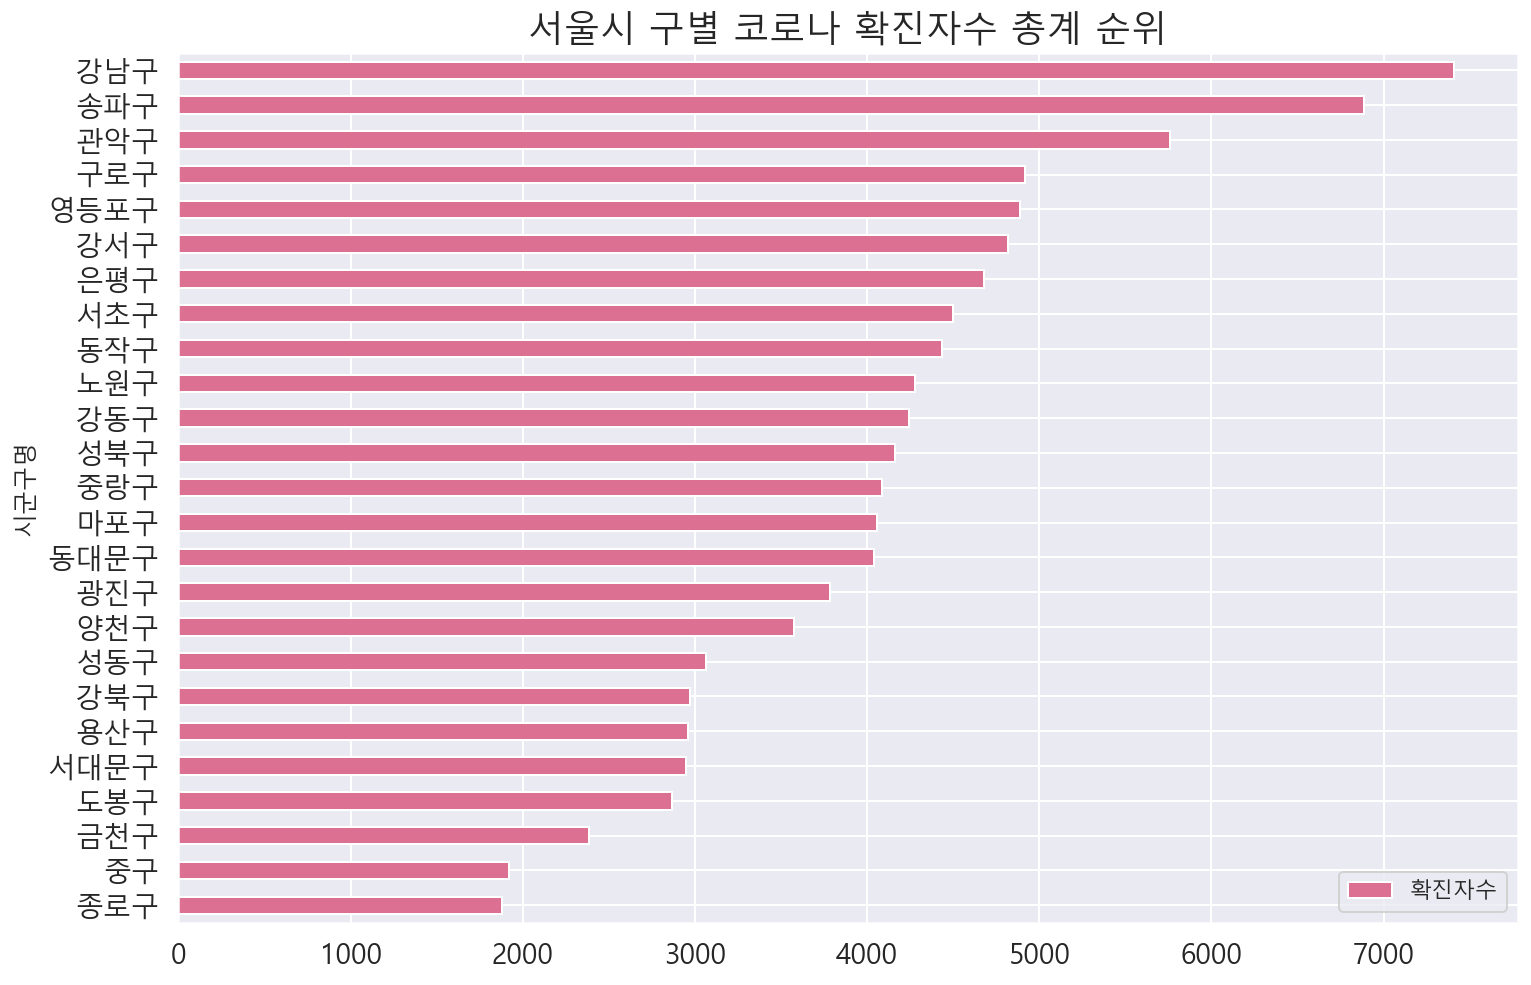

In [46]:
df_corona_seoul.sort_values(by='확진자수').plot.barh(color='palevioletred', figsize=(12,8), fontsize=14)
plt.title('서울시 구별 코로나 확진자수 총계 순위', fontsize=18)

## folium 활용한 <코로나 확진자> 지도 choropleth 시각화
* 구별로 확진자수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)

In [39]:
import folium
import json

geo_path = './data/skorea_municipalities_geo_simple.json'
geo_json = json.load(open(geo_path, encoding='utf-8'))

In [40]:
# 지도 그리기 위해 앞에서 처리한 서울시 상권 위도, 경도 데이터 로딩
df_shop_seoul = pd.read_csv('./data/df_shop_seoul.csv')
df_shop_seoul.head()


,상호명,지점명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,지번주소,도로명주소,경도,위도
0,비지트,NaN,음식,한식,한식/백반/한정식,서울특별시,서초구,방배4동,방배동,서울특별시 서초구 방배동 854-18,서울특별시 서초구 동광로18길 82,126.991394,37.488375
1,쓰리에프,NaN,음식,한식,한식/백반/한정식,서울특별시,동작구,사당2동,사당동,서울특별시 동작구 사당동 139-72,서울특별시 동작구 동작대로27가길 12,126.980952,37.487105
2,채움,NaN,음식,한식,한식/백반/한정식,서울특별시,종로구,종로1.2.3.4가동,수송동,서울특별시 종로구 수송동 58,서울특별시 종로구 삼봉로 81,126.981794,37.572387
3,호구의주방,NaN,소매,가정/주방/인테리어,주방가구판매,서울특별시,영등포구,양평2동,양평동4가,서울특별시 영등포구 양평동4가 160-2,서울특별시 영등포구 선유로 269,126.897892,37.536700
4,다향,NaN,음식,한식,한식/백반/한정식,서울특별시,서초구,서초3동,서초동,서울특별시 서초구 서초동 1485-3,서울특별시 서초구 효령로 230,127.009382,37.483436


In [59]:
df_corona_seoul

,확진자수
시군구명,
강남구,7296
강동구,4183
강북구,2923
강서구,4758
관악구,5703
광진구,3730
구로구,4774
금천구,2328
노원구,4198


In [61]:
# https://python-visualization.github.io/folium/quickstart.html
# https://matplotlib.org/stable/gallery/color/colormap_reference.html

map = folium.Map(location=[df_shop_seoul['위도'].mean(), df_shop_seoul['경도'].mean()], 
                 zoom_start=11)

map.choropleth(geo_data = geo_json,
               data = df_corona_seoul['확진자수'],
               columns = [df_shop_seoul.index, df_corona_seoul['확진자수']],
               fill_color = 'BuPu',
               key_on = 'feature.properties.name',
               fill_opacity=0.7,
               line_opacity=0.2,
               highlight=True)
map

## 구별 음식점수, 쓰레기 배출량과 코로나 발생의 상관관계 (학습용)
* 음식점수, 쓰레기 배출량, 코로나 확진 측정 시기와 기준이 다릅니다 (통계 자료)
* 실제로 상관관계를 보려면 기준/기간을 동일하게 하여 측정한 데이터를 사용해야 합니다
* 여기에서는 "학습" 차원에서, 여러 데이터를 합쳐 변수간 상관관계를 살펴보는 방법을 실습합니다

In [22]:
# 앞에서 처리한 서울시 구별 음식점 수 csv 데이터 로딩
df_food_seoul = pd.read_csv('./data/df_food_seoul.csv')
df_food_seoul

,시군구명,음식점수
0,강남구,12723
1,마포구,7684
2,송파구,7348
3,서초구,6610
4,강서구,6393
5,영등포구,6389
6,관악구,5387
7,강동구,5181
8,종로구,5158
9,중구,4869


In [23]:
# 앞에서 처리한 서울시 구별 쓰레기 배출량 csv 데이터 로딩
df_garbage_seoul = pd.read_csv('./data/df_garbage_seoul.csv')
df_garbage_seoul

,시군구명,배출량
0,송파구,38265512065
1,도봉구,34790954457
2,노원구,32942231384
3,마포구,20825545358
4,영등포구,18647711639
5,강동구,14253903549
6,양천구,12177225579
7,중랑구,11582342110
8,동작구,11450788663
9,서대문구,11004141699


In [24]:
df_food_garbage = pd.merge(df_food_seoul, df_garbage_seoul)
df_food_garbage

,시군구명,음식점수,배출량
0,강남구,12723,1418405631
1,마포구,7684,20825545358
2,송파구,7348,38265512065
3,서초구,6610,9714324358
4,강서구,6393,7844540723
5,영등포구,6389,18647711639
6,관악구,5387,4566695953
7,강동구,5181,14253903549
8,종로구,5158,2390357650
9,중구,4869,4395584448


In [25]:
# '시군구명' 기준으로 결합시키기 위해 시군구명이 인덱스가 아니라 컬럼인 df_corona 데이터 사용
df_food_garbage_corona = pd.merge(df_food_garbage, df_corona)
df_food_garbage_corona 

,시군구명,음식점수,배출량,확진자수
0,강남구,12723,1418405631,7408
1,마포구,7684,20825545358,4060
2,송파구,7348,38265512065,6888
3,서초구,6610,9714324358,4500
4,강서구,6393,7844540723,4821
5,영등포구,6389,18647711639,4888
6,관악구,5387,4566695953,5761
7,강동구,5181,14253903549,4242
8,종로구,5158,2390357650,1879
9,중구,4869,4395584448,1922


In [26]:
df_food_garbage_corona.describe() #

,음식점수,배출량,확진자수
count,25.000000,2.500000e+01,25.000000
mean,5048.120000,1.131163e+10,4060.760000
std,2064.582349,1.041689e+10,1344.759095
min,2690.000000,2.201854e+08,1879.000000
25%,3917.000000,4.395584e+09,2971.000000
50%,4583.000000,8.487977e+09,4086.000000
75%,5387.000000,1.217723e+10,4677.000000
max,12723.000000,3.826551e+10,7408.000000


In [48]:
# 확진자수가 숫자형 아닐 경우
df_food_garbage_corona['확진자수'] = pd.to_numeric(df_food_garbage_corona['확진자수'], errors='coerce')

In [27]:
df_food_garbage_corona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시군구명    25 non-null     object
 1   음식점수    25 non-null     int64 
 2   배출량     25 non-null     int64 
 3   확진자수    25 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1000.0+ bytes


Text(0.5, 1.0, '구별 음식물 쓰레기 양과 코로나 확진자수의 관계')

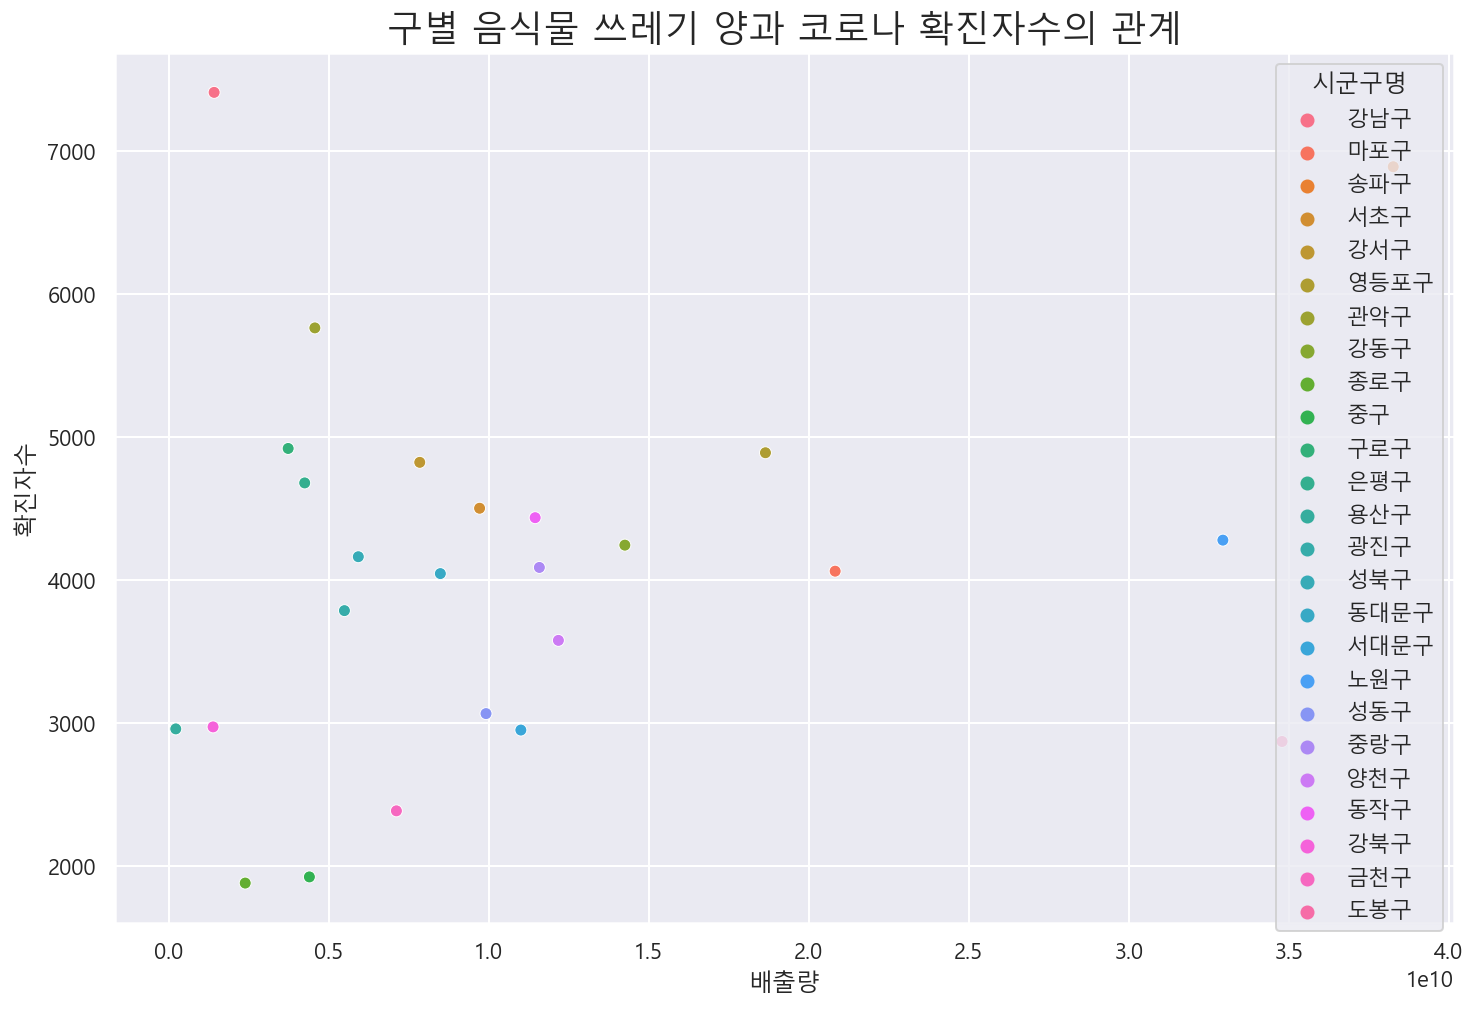

In [38]:
plt.figure(figsize = (12,8))
sns.scatterplot(x='배출량', y='확진자수', hue='시군구명', data=df_food_garbage_corona)
plt.title('구별 음식물 쓰레기 양과 코로나 확진자수의 관계', fontsize=18)

Text(0.5, 1.0, '구별 음식물 쓰레기 배출량과 코로나 발생의 관계 - 회귀선 추가')

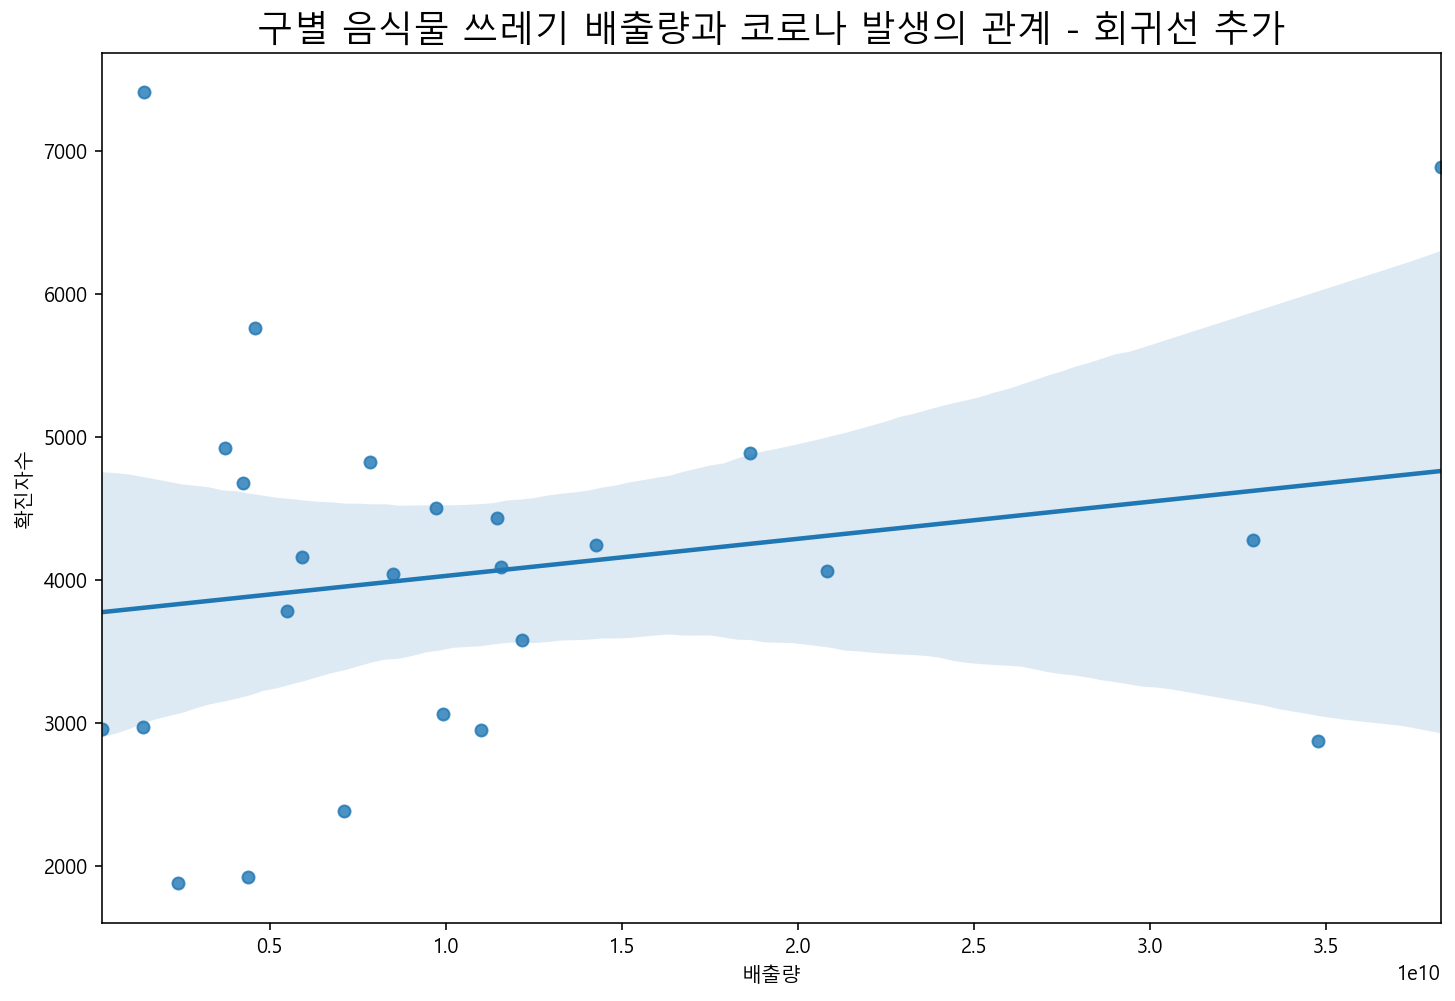

In [31]:
plt.figure(figsize = (12,8))
sns.regplot(x='배출량', y='확진자수', data=df_food_garbage_corona)
plt.title('음식물 쓰레기 양과 코로나 확진자수의 관계 - 회귀선 추가', fontsize=18)

Text(0.5, 1.0, '구별 음식점수와 코로나 발생의 관계 - 회귀선 추가')

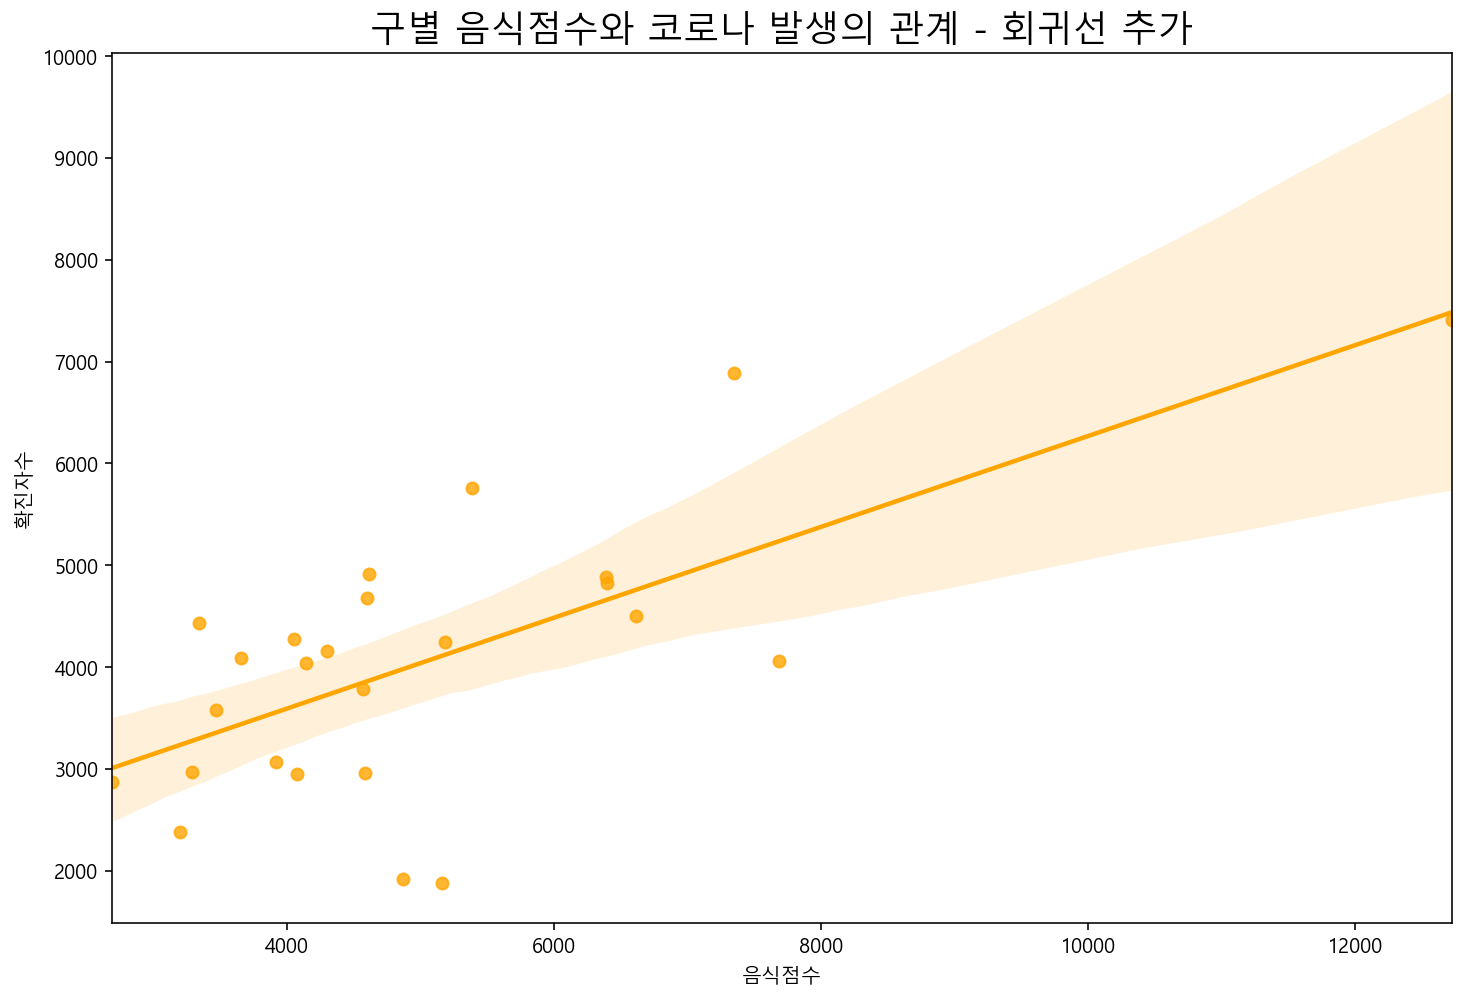

In [32]:
plt.figure(figsize = (12,8))
sns.regplot(x='음식점수', y='확진자수', color='orange', data=df_food_garbage_corona)
plt.title('음식점수와 코로나 발생의 관계 - 회귀선 추가', fontsize=18)

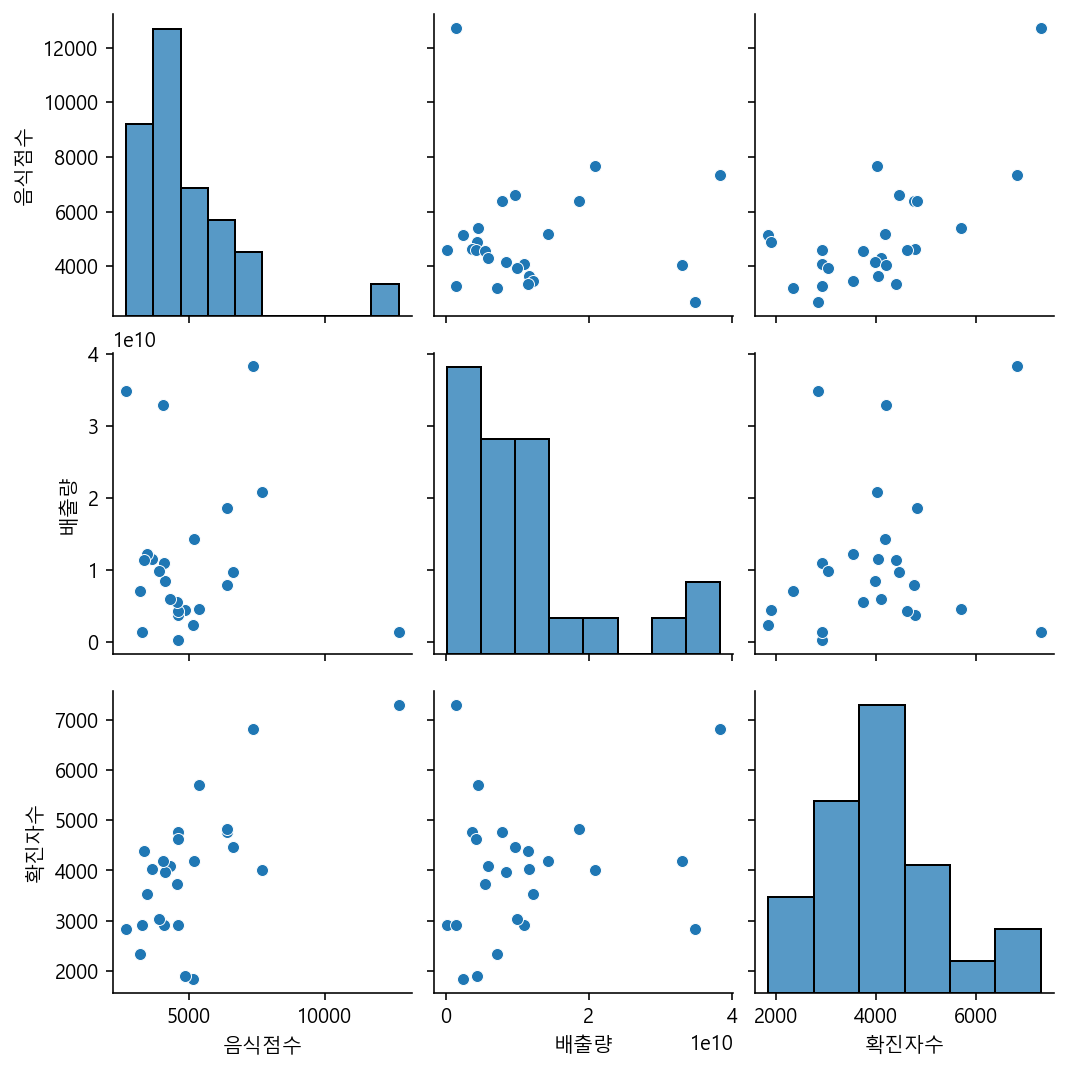

In [53]:
sns.pairplot(df_food_garbage_corona)

In [54]:
df_food_garbage_corona.corr()

,음식점수,배출량,확진자수
음식점수,1.000000,-0.036131,0.685306
배출량,-0.036131,1.000000,0.204424
확진자수,0.685306,0.204424,1.000000


Text(0.5, 1.03, '음식점 수, 음식물 쓰레기 양, 코로나 확진자수의 상관관계')

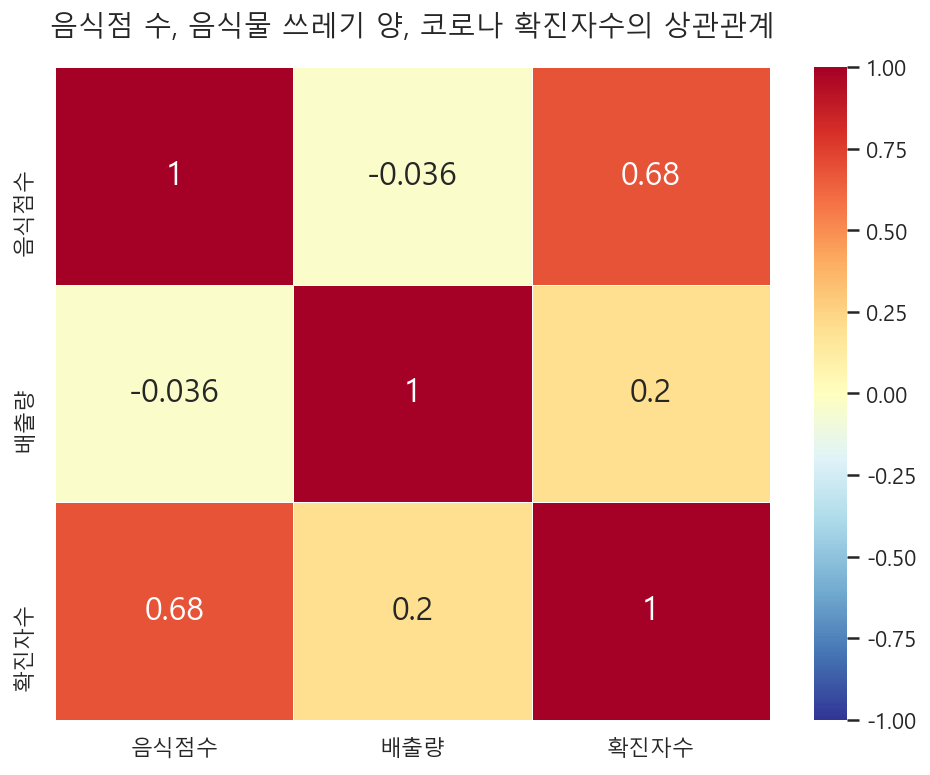

In [47]:
# https://m.blog.naver.com/kiddwannabe/221763497317

plt.figure(figsize = (8, 6))
sns.heatmap(df_food_garbage_corona.corr(), 
            annot = True,      
            cmap = 'RdYlBu_r',
            linewidths=.5, 
            vmin = -1, vmax = 1, 
            annot_kws={"size": 16}
            )
plt.title('음식점 수, 음식물 쓰레기 양, 코로나 확진자수의 상관관계', y=1.03, fontsize=14)

<AxesSubplot:>

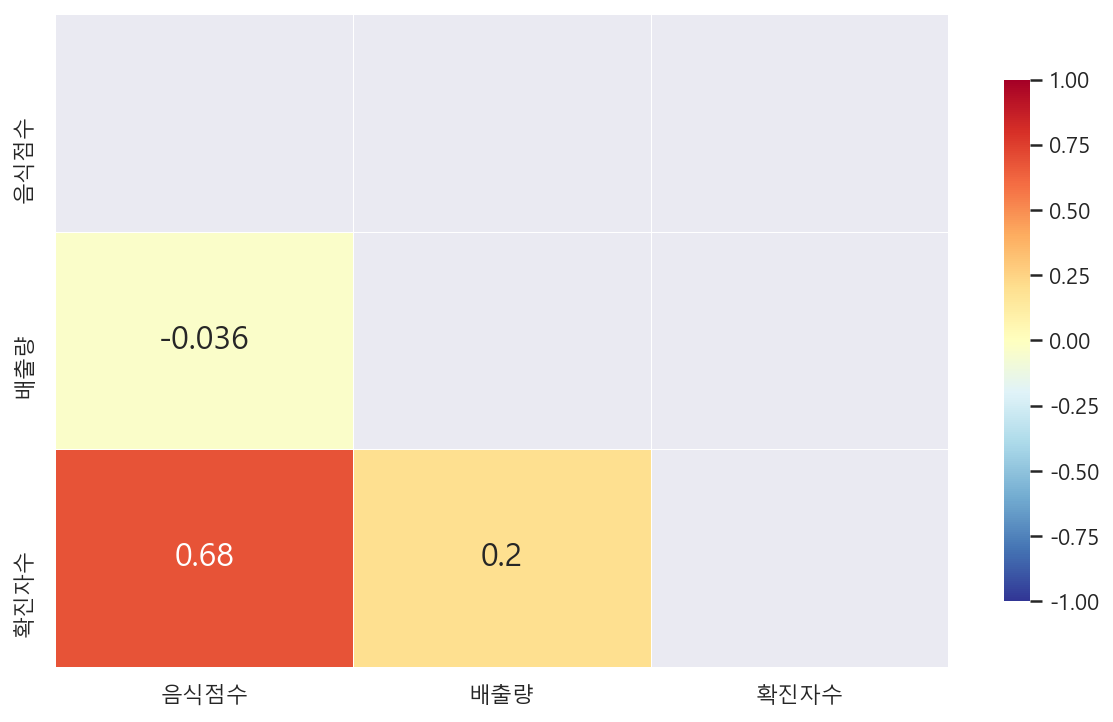

In [43]:
mask = np.zeros_like(df_food_garbage_corona.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,6))

sns.heatmap(df_food_garbage_corona.corr(), 
            annot = True,  
            mask = mask,   
            cmap = 'RdYlBu_r',  
            linewidths=.5, 
            cbar_kws={"shrink": .8},
            vmin = -1, vmax = 1, 
            annot_kws={"size": 16}
            )
# plt.title('음식점 수, 음식물 쓰레기 양, 코로나 확진자수의 상관관계', fontsize=14)

* 음식점수 - 확진자수 상관관게 0.69
* 음식점수와 쓰레기 배출량 상관관계는 없음 (매우 약함)
* 확진자수와 쓰레기 배출량은 약한 상관관계 보이므로 추가 분석 필요

* 상관관계와 인과관계는 다르다
* 식당에서의 접촉이 많은 구에 확진자가 많이 발생?
* 단순히 인구 수에 비례해 음식점수와 확진자가 우연히 같이 많이 발생?
* 음식점수와 쓰레기 배출량은 거의 무관
* 확진자수와 쓰레기 배출량은 약한 양의 상관관계

### 재현을 위해 csv로 저장

In [56]:
# df_food_garbage_corona.to_csv('./data/df_food_garbage_corona.csv', index=False)
df_food_garbage_corona.to_csv('./data/df_food_garbage_corona2.csv', index=False)

In [57]:
df = pd.read_csv('./data/df_food_garbage_corona.csv')
df

,시군구명,음식점수,배출량,확진자수
0,강남구,12723,1418405631,7146
1,마포구,7684,20825545358,3889
2,송파구,7348,38265512065,6606
3,서초구,6610,9714324358,4380
4,강서구,6393,7844540723,4627
5,영등포구,6389,18647711639,4654
6,관악구,5387,4566695953,5580
7,강동구,5181,14253903549,4000
8,종로구,5158,2390357650,1745
9,중구,4869,4395584448,1824


In [58]:
df2 = pd.read_csv('./data/df_food_garbage_corona2.csv')
df2

,시군구명,음식점수,배출량,확진자수
0,강남구,12723,1418405631,7296
1,마포구,7684,20825545358,4012
2,송파구,7348,38265512065,6815
3,서초구,6610,9714324358,4463
4,강서구,6393,7844540723,4758
5,영등포구,6389,18647711639,4817
6,관악구,5387,4566695953,5703
7,강동구,5181,14253903549,4183
8,종로구,5158,2390357650,1842
9,중구,4869,4395584448,1899
